ratio:  20
R:  0.9006430410565854
directness= 2
alpha: 1000 must be greater than 500
h coarse: 48.0


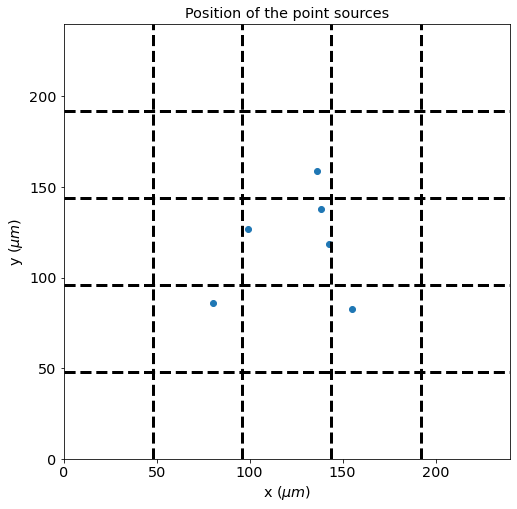

In [1]:
import pdb
import numpy as np 
import matplotlib.pyplot as plt
from module_2D_coupling_FV_nogrid import * 
import reconst_and_test_module as post
import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8,8 ),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth': 3}
pylab.rcParams.update(params)


#0-Set up the sources
#1-Set up the domain
alpha=1000

Da_t=15

D=1
C0=1


L=240

M=Da_t*D/L**2
phi_0=0.4
cells=5
h_ss=L/cells
ratio=int(50/cells)*2
print("ratio: ", ratio)
#ratio=12
#Rv=np.exp(-2*np.pi)*h_ss


print("R: ", 1/(1/C0 + np.log(alpha/(5*cells*ratio))/(2*np.pi*D)))


conver_residual=5e-5

stabilization=0.5

validation=True
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(np.around(L/h_ss)))
y_ss=x_ss
directness=2
print("directness=", directness)
#pos_s=np.array([[x_ss[2], y_ss[2]],[x_ss[4], y_ss[4]]])
#pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6],[2,2]])-np.array([0.25,0.25])
#pos_s/=2
#pos_s=np.array([[1.25,1.25],[1.25,1.75], [1.75,1.75],[1.75,1.25]])
#pos_s=np.array([[4.3,4.3],[4.3,5.5], [3.5,4.5],[3.5,3.5]])


#pos_s=np.array([[0.41,0.41],[0.7,0.7],[0.3,0.47],[0.8,0.2]])*L
pos_s=np.array([[0.47,0.47],[0.53,0.53]])*L
pos_s1=np.array([[0.45,0.02],[0.24,0.17],[0.6,0.23],[0.23,0.27],[0.55,0.33],[1.02,0.41],[0.96,0.43]])
pos_s2=np.array([[0.27,0.6],[0.55,0.65],[0.59,0.66],[0.67,0.67],[0.13,0.75],[0.15,0.93],[0.2,0.87],[0.28,0.98],[0.8,0.85],[0.83,0.92]])
pos_s=(np.concatenate((pos_s1, pos_s2))*0.8+0.1)*L
pos_s=(np.array([[0.45,0.02],[0.24,0.17],[0.6,0.23],[0.23,0.27],[0.55,0.33],[1.02,0.41],[0.96,0.43]])*0.6+0.2)*L
#pos_s=np.array([[0.5,0.5]])*L
pos_s=(np.random.random((6,2))*0.6+0.2)*L

pos_s=(np.array([[2.4746205 , 3.84194922],
       [1.56678779, 1.85388858],
       [4.28902858, 5.38971457],
       [5.19870931, 1.67982104],
       [4.39671925, 4.37907858],
       [4.59228223, 3.44110346]])/7*0.6+0.2)*L


S=len(pos_s)

Rv=L/alpha+np.zeros(S)

print("alpha: {} must be greater than {}".format(alpha, 5*ratio*cells))
print("h coarse:",h_ss)
K_eff=C0/(np.pi*Rv**2)

#Position image

vline=(y_ss[1:]+x_ss[:-1])/2
plt.scatter(pos_s[:,0], pos_s[:,1])
plt.title("Position of the point sources")
for xc in vline:
    plt.axvline(x=xc, color='k', linestyle='--')
for xc in vline:
    plt.axhline(y=xc, color='k', linestyle='--')
plt.xlim([0,L])
plt.ylim([0,L])
plt.ylabel("y ($\mu m$)")
plt.xlabel("x ($\mu m$)")
plt.show()


p=np.linspace(0,1,100)
if np.min(p-M*(1-phi_0/(phi_0+p)))<0: print("There is an error in the metabolism")


C_v_array=np.ones(S)   
C_v_array[2:4]=0

In [2]:
FV=FV_validation(L, cells*ratio, pos_s, C_v_array, D, K_eff, Rv)
FV_linear=FV.solve_linear_system()
FV_linear_rcr=FV_linear.copy()
FV_linear_rcr[FV.s_blocks]+=FV.get_corr_array(FV_linear)

FV_linear_mat=FV_linear.reshape(cells*ratio, cells*ratio)
FV_linear_rcr_mat=FV_linear_rcr.reshape(cells*ratio, cells*ratio)

#%%
print("R: ", 1/(1/C0 + np.log(0.2*FV.h/Rv)/(2*np.pi*D)))



TypeError: __init__() missing 1 required positional argument: 'dirichlet_array'

In [3]:
#%% Plots FV reference solution - Peaceman Coupling

plt.imshow(FV_linear_rcr_mat, origin='lower', extent=[0,L,0,L])
plt.colorbar()
plt.title("FV reference solution, linear system\n mesh:{}x{}".format(ratio*cells, ratio*cells))
plt.show()




NameError: name 'FV_linear_rcr_mat' is not defined

In [4]:
#Linear system with coupling model
n=non_linear_metab(pos_s, Rv, h_ss, L, K_eff, D, directness)
n.solve_linear_prob(np.zeros(4), C_v_array)



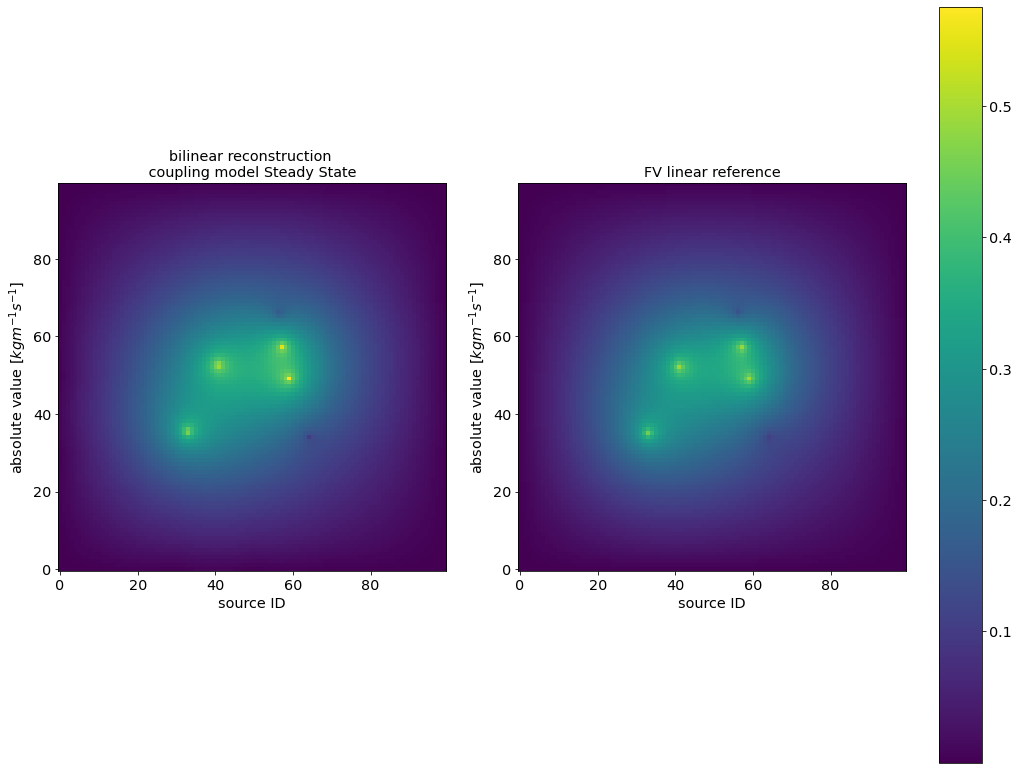

In [5]:
b=post.reconstruction_sans_flux(np.concatenate((np.ndarray.flatten(n.phi_FV), n.phi_q)), n, L,ratio, directness)
p=b.reconstruction()   
b.reconstruction_boundaries(np.array([0,0,0,0]))
b.rec_corners()

fig, axs = plt.subplots(1,2, figsize=(15,15))
fig.tight_layout(pad=4.0)
im=axs[0].imshow(b.rec_final, origin='lower')
axs[0].set_title("bilinear reconstruction \n coupling model Steady State ")
axs[0].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[0].set_xlabel("source ID")


axs[1].imshow(FV_linear_rcr_mat, origin='lower',vmax=np.max(FV_linear_mat*1.1))
axs[1].set_title("FV linear reference")
axs[1].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[1].set_xlabel("source ID")
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)


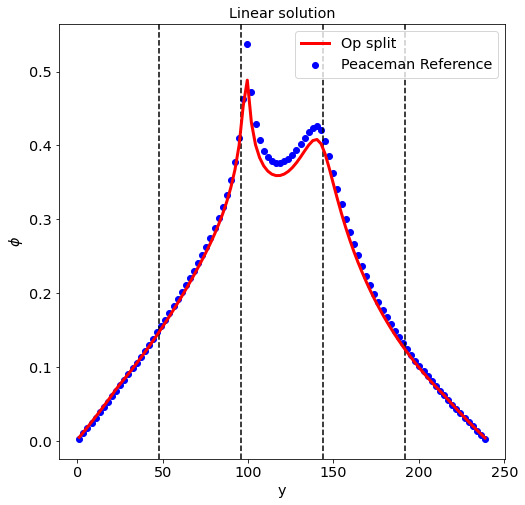

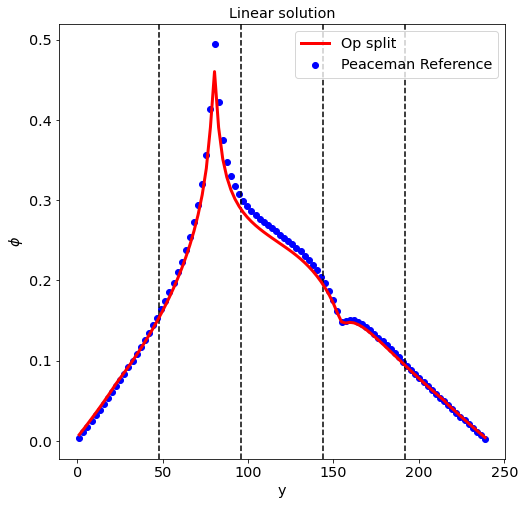

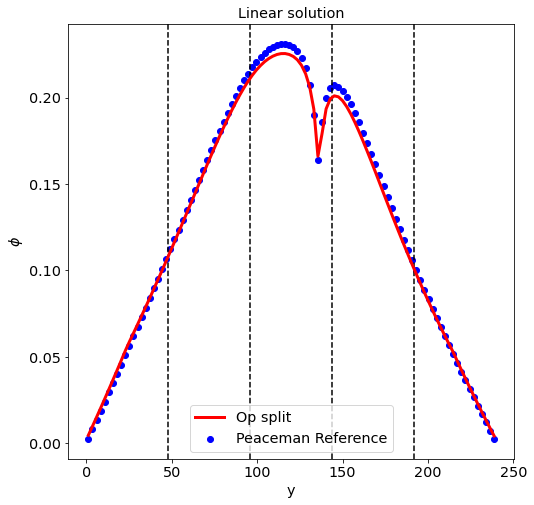

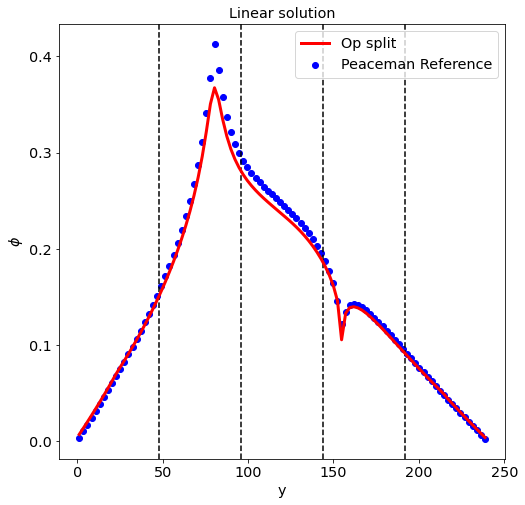

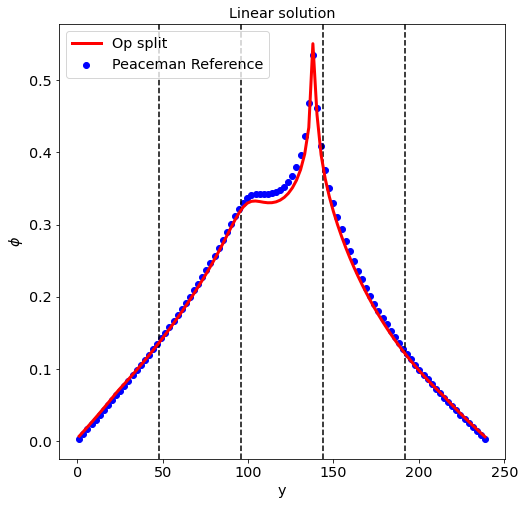

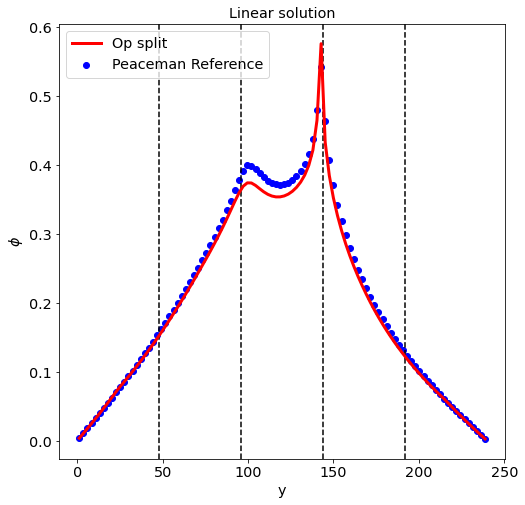

In [6]:
#manual q
q_array_linear=-np.dot(FV.A_virgin.toarray()[FV.s_blocks,:],FV_linear)*FV.h**2/D
for i in pos_s:
    pos=coord_to_pos(FV.x, FV.y, i)
    
    plt.scatter(FV.x,FV_linear_rcr_mat[pos//len(FV.x),:], label="Peaceman Reference", color='b')
    for xc in vline:
        plt.axvline(x=xc, color='k', linestyle='--', linewidth=1.5)
    plt.plot(FV.x,b.rec_final[pos//len(FV.x),:],label="Op split", color='r')
    plt.legend()
    plt.xlabel("y")
    plt.ylabel("$\phi$")
    plt.title("Linear solution")
    plt.show()

Residual q FV:  0.11601520852418003
Residual q FV:  0.031676614301696306
Residual q FV:  0.009275982288796083
Residual q FV:  0.003113628891904172
Residual q FV:  0.0011738429320075601
Residual q FV:  0.0004766014194332503
Residual q FV:  0.00020442428399033877
Residual q FV:  9.052933726870416e-05
Residual q FV:  4.0581255975540545e-05


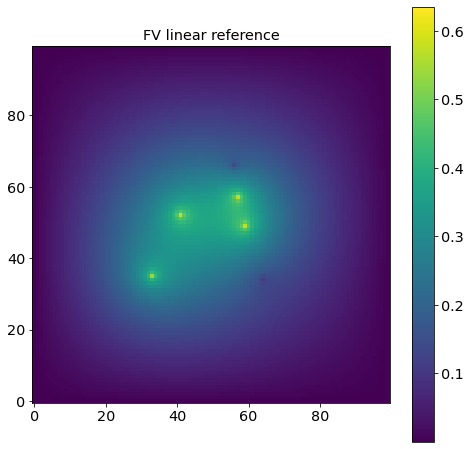

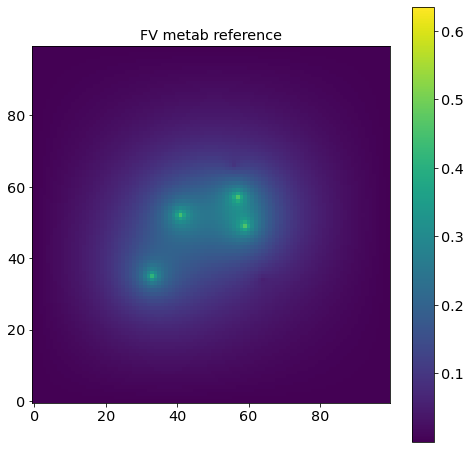

In [7]:
#%% 5
FV_non_linear=FV.solve_non_linear_system(phi_0,M, stabilization)
#phi_FV=FV_linear.reshape(cells*ratio, cells*ratio)
phi_FV=(FV.phi[-1]+FV.Corr_array).reshape(cells*ratio, cells*ratio)


#%%

plt.imshow(FV_linear_mat, origin='lower',vmax=np.max(FV_linear_mat*1.1))
plt.title("FV linear reference")
plt.colorbar(); plt.show()


#%%
plt.imshow(phi_FV, origin='lower', vmax=np.max(FV_linear_mat*1.1))
plt.title("FV metab reference")
plt.colorbar(); plt.show()


#manual q
q_array=-np.dot(FV.A_virgin.toarray()[FV.s_blocks,:],FV.phi[-1])*FV.h**2/D+M*(1-phi_0/(FV.phi[-1, FV.s_blocks]+FV.Corr_array[FV.s_blocks]+phi_0))

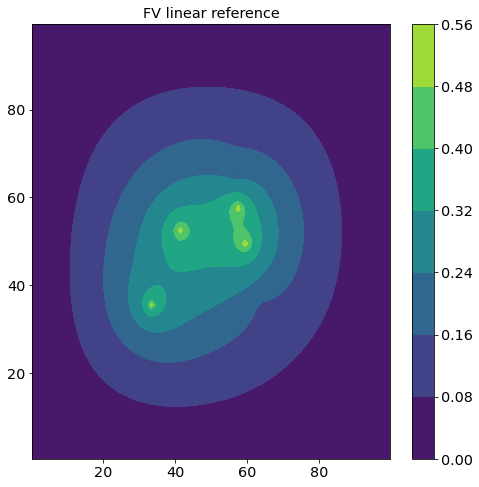

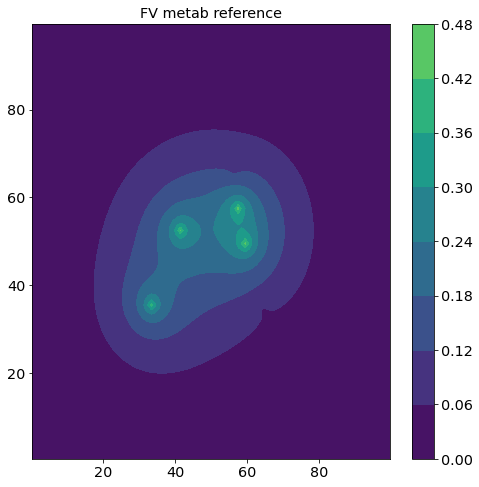

In [10]:

#%%

plt.contourf(FV_linear_mat, origin='lower',vmax=np.max(FV_linear_mat*1.1))
plt.title("FV linear reference")
plt.colorbar(); plt.show()


#%%
plt.contourf(phi_FV, origin='lower', vmax=np.max(FV_linear_mat*1.1))
plt.title("FV metab reference")
plt.colorbar(); plt.show()


In [ ]:
#manual q
q_array=-np.dot(FV.A_virgin.toarray()[FV.s_blocks,:],FV.phi[-1])*FV.h**2/D+M*(1-phi_0/(FV.phi[-1, FV.s_blocks]+FV.Corr_array[FV.s_blocks]+phi_0))


In [ ]:
print("MRE steady state system", get_MRE(n.phi_q, FV.get_q(FV_linear)))
print("\nMAE q estimation linear", get_MAE(n.phi_q, FV.get_q(FV_linear)))

plt.plot(np.arange(S),n.phi_q, label="MyCode", marker='o')
plt.plot(np.arange(S),FV.get_q(FV_linear), label="FV Peaceman reference", marker='o')
plt.title("Individual value of q for each source")
plt.xlabel("source ID")
plt.ylabel("q magnitude")
plt.legend()
plt.show()


In [ ]:
n.Full_Newton(np.ndarray.flatten(n.phi_FV) , np.ndarray.flatten(n.phi_q), conver_residual, M, phi_0)
a=post.reconstruction_sans_flux(n.phi[-1], n, L,ratio, directness)
p=a.reconstruction()   
a.reconstruction_boundaries(np.array([0,0,0,0]))
a.rec_corners()


fig, axs = plt.subplots(1,2, figsize=(15,15))
fig.tight_layout(pad=4.0)
im=axs[0].imshow(a.rec_final, origin='lower', vmax=np.max(phi_FV*1.1))
axs[0].set_title("bilinear $\Omega$ reconstruction \n coupling model Metabolism")
axs[0].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[0].set_xlabel("source ID")

axs[1].imshow(phi_FV, origin='lower', vmax=np.max(phi_FV*1.1))
axs[1].set_title("FV metab reference")
axs[1].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[1].set_xlabel("source ID")
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)

n.assemble_it_matrices_Sampson(n.u, n.q)


In [ ]:

plt.subplots(1,2, figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(n.phi[-1,-S:], label="MyCode", marker='o')
plt.plot(FV.get_q(FV.phi[-1]), label="FV reference", marker='o')
plt.xlabel("source ID")
plt.ylabel("magnitude q")
plt.title("flux q estimation metabolism")
plt.legend()
plt.subplot(1,2,2)
plt.plot(n.phi_q, label="MyCode", marker='o')
plt.plot(FV.get_q(FV_linear), label="FV reference", marker='o')
plt.xlabel("source ID")
plt.ylabel("magnitude q")
plt.legend()
plt.title("Flux q estimation linear problem")
plt.show()

print("\nMRE q estimation non_linear", get_MRE(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))
print("\nMAE q estimation non_linear", get_MAE(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))
print("\nMRE q estimation linear", get_MRE(n.phi_q, FV.get_q(FV_linear)))
print("\nMAE q estimation linear", get_MAE(n.phi_q, FV.get_q(FV_linear)))


In [ ]:
c=0
for i in pos_s:
    pos=coord_to_pos(FV.x, FV.y, i)
    for xc in vline:
        plt.axvline(x=xc, color='k', linestyle='--', linewidth=1.5)

    plt.scatter(FV.x,FV_linear_rcr_mat[pos//len(FV.x),:], label="FV no metab", marker='o', color='b')
    plt.scatter(FV.x,phi_FV[pos//len(FV.x),:], label="FV", marker='o',color='g')
    plt.plot(FV.x,a.rec_final[pos//len(FV.x),:],label="SS", color='r')
    plt.plot(FV.x,b.rec_final[pos//len(FV.x),:],label="SS no metab", color='y')
    plt.title("Concentration plot along source {}".format(c))
    plt.xlabel("x $\mu$m")
    plt.ylabel("$\phi$")
    plt.legend()
    plt.show()
    c+=1

# =============================================================================
# c=0
# for i in pos_s:
#     pos=coord_to_pos(FV.x, FV.y, i)
#     
#     plt.plot(FV.x,phi_FV[pos//len(FV.x),:], label="FV")
#     plt.scatter(n.x,(n.rec_sing+n.u).reshape(cells, cells)[n.s_blocks[c]//cells,:],label="SS")
#     plt.plot(b.x,b.rec_final[pos//len(FV.x),:],label="SS no metab")
#     plt.legend()
#     plt.show()
#     c+=1
# =============================================================================



In [ ]:
print("relative errors in the q estimation metabolism")
print(np.abs(n.phi[-1,-S:]-FV.get_q(FV.phi[-1]))/FV.get_q(FV.phi[-1]))

print("\nabsolute error in the q estimation metabolism")
print(np.abs(n.phi[-1,-S:]-FV.get_q(FV.phi[-1])))

print("\nL2_error in the q estimation metabolism")
print(get_L2(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))

print("\nMRE q estimation non_linear", get_MRE(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))

print("\nMAE q estimation non_linear", get_MAE(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))
print("\nMAE q estimation linear", get_MAE(n.phi_q, FV.get_q(FV_linear)))



